#Image caption model (InceptionV3-LSTM)

##Introduction

In this notebook I am going to tackle an image caption model. 

To do so, I am going to implement the following architecture:
- Image feature extractor CNN: InceptionV3 (without the classification layer)
- Text generator RNN: LSTM.

Lastly I am going to see how Beam Search algorithm performs when applied to LSTM text generator models.

## Preparing context


In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
import nltk
import random

Using TensorFlow backend.


In [3]:
# If we do not have the file: download it.
! [ ! -f Flickr8k_text.zip ] && wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
# If it is not unzipped: unzip it. 
! [ ! -f Flickr_8k.testImages.txt ] && unzip -o Flickr8k_text.zip

# rm -rf __MACOSX


Redirecting output to ‘wget-log’.
Archive:  Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              


In [4]:
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip -q Flickr8k_Dataset.zip


Redirecting output to ‘wget-log.1’.


In [5]:
! df -h . 
! ls -l

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  9.7G  331G   3% /
total 1101924
-rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
drwxr-xr-x 2 root root     417792 Oct  3  2012 Flicker8k_Dataset
-rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
-rw-r--r-- 1 root root    3395237 Oct 14  2013 Flickr8k.token.txt
-rw-r--r-- 1 root root     154678 Oct 10  2013 Flickr_8k.trainImages.txt
drwxrwxr-x 3 root root       4096 Sep  8 23:41 __MACOSX
-rw-r--r-- 1 root root       1821 Oct 14  2013 readme.txt
drwxr-xr-x 2 root root       4096 Sep  6 17:46 sample_data
-rw-r--r-- 1 root root       

## Creating a dictionary containing all the captions of the images

In [6]:
token = 'Flickr8k.token.txt'

captions = open(token, 'r').read().strip().split('\n')

d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]
        
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
images = 'Flicker8k_Dataset/'
# Contains all the images
img = glob.glob(images+'*.jpg')
img[:5]

['Flicker8k_Dataset/2797188545_aeb26c54c0.jpg',
 'Flicker8k_Dataset/246041128_bedb09ed74.jpg',
 'Flicker8k_Dataset/3159424456_f316bdc1d5.jpg',
 'Flicker8k_Dataset/3425061393_d093edb8da.jpg',
 'Flicker8k_Dataset/3143155555_32b6d24f34.jpg']

In [0]:
train_images_file = 'Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [9]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp
  
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [10]:
val_images_file = 'Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [11]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

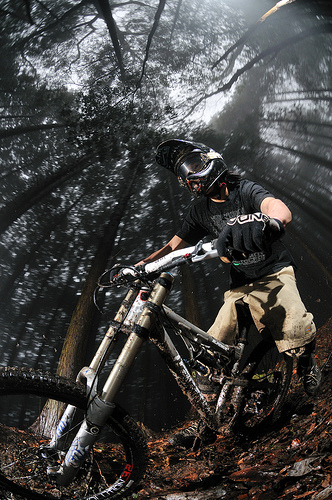

In [12]:
Image.open(train_img[random.randint(0,1000)])

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299)) #InceptionV3 input shape images have to be 299x299
    x = image.img_to_array(img) #In order to work with the values
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #InceptionV3 input shape images have to have pixel values like between -1 and 1
    return x

In [14]:
model = InceptionV3(weights='imagenet') #It is convenient initialize Inception models on imagenet in order to reduce convergence time

96116736/96112376 [==============================] - 26s 0us/step


In [15]:
from keras.models import Model

new_input = model.input

hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

tryi = model_new.predict(preprocess(train_img[0]))

tryi.shape #Make sure that is the shape we want 

(1, 2048)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [17]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
    
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 
    
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

encoding_train['3556792157_d09d42bef7.jpg'].shape

100%|██████████| 6000/6000 [04:48<00:00, 20.81it/s]


(2048,)

In [18]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
    
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 
    
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

encoding_test[test_img[0][len(images):]].shape

100%|██████████| 1000/1000 [00:48<00:00, 20.81it/s]


(2048,)

In [19]:
train_d = {}
m=0
for i in train_img:
    if i[len(images):] in d and m<512:
        train_d[i] = d[i[len(images):]]
    m+=1
    

val_d = {}
n=0
for i in val_img:
    if i[len(images):] in d and n<64:
        val_d[i] = d[i[len(images):]]
    n+=1
    

test_d = {}
o=0
for i in test_img:
    if i[len(images):] in d and o<30:
        test_d[i] = d[i[len(images):]]
    o+=1

print(len(train_d),len(val_d),len(test_d))

512 64 30


####Calculating the unique words in the vocabulary.

In [20]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')
        
words = [i.split() for i in caps]

unique = []
for i in words:
    unique.extend(i)
    
unique = list(set(unique))

with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d) 
    
unique = pickle.load(open('unique.p', 'rb'))
len(unique)

2385

####Mapping the unique words to indices and vice-versa

In [21]:
word2idx = {val:index for index, val in enumerate(unique)}
word2idx['<start>']

2283

In [22]:
idx2word = {index:val for index, val in enumerate(unique)}
idx2word[855]

'apron'

####Calculating the maximum length among all the captions

In [23]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

len(unique), max_len

(2385, 34)

In [24]:
vocab_size = len(unique)
vocab_size

2385

####Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [25]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [26]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
len(df)

2560

In [27]:
c = [i for i in df['captions']]
# len(c)

imgs = [i for i in df['image_id']]

a = c[-1]
a, imgs[-1]

('<start> A picture of somebody under blue water . <end>',
 '3683644335_b70bed1d83.jpg')

In [28]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 2283
A => 852
picture => 2268
of => 2239
somebody => 402
under => 1791
blue => 1900
water => 1548
. => 1689
<end> => 2209


## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])

        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [30]:
embedding_size = 300
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'), #Input dimension is 2048 since we will feed it the encoded version of the image.
        RepeatVector(max_len)
    ])

caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),  # Since we are going to predict the next word using the previous words(length of previous
        LSTM(256, return_sequences=True),                             # words changes with every iteration over the caption), we have to set return_sequences = True.
        TimeDistributed(Dense(300))
    ])

from keras.layers import Merge
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1), # Merging the models and creating a softmax classifier
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

final_model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 68, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 2385)              1223505   
_________________________________________________________________
activation_95 (Activation)   (None, 2385)              0         
Total params: 4,341,909
Trainable params: 4,341,909
Non-trainable params: 0
_________________________________________________________________


####Training the model

In [31]:
#After various numbers this seems to be the optimal one taking into account my limited GPU capacity
steps_per_epoch = 512 
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=steps_per_epoch, nb_epoch=1, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=512, epochs=1)`
  


Epoch 1/1
 - 212s - loss: 4.8086 - acc: 0.2093


In [38]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=steps_per_epoch, nb_epoch=1, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=512, epochs=1)`
  """Entry point for launching an IPython kernel.


Epoch 1/1
 - 209s - loss: 3.9951 - acc: 0.2944


In [39]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=steps_per_epoch, nb_epoch=2, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=512, epochs=2)`
  """Entry point for launching an IPython kernel.


Epoch 1/2
 - 211s - loss: 3.4118 - acc: 0.3559
Epoch 2/2
 - 208s - loss: 3.0757 - acc: 0.3865


## Predict funtion

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])
  
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

Normal Max search: A man in a beard is walking down a sidewalk .
Beam Search, k=3: A group of people dressed dressed in a orange jacket stands on a sidewalk .
Beam Search, k=5: A group of people stand on a sidewalk .


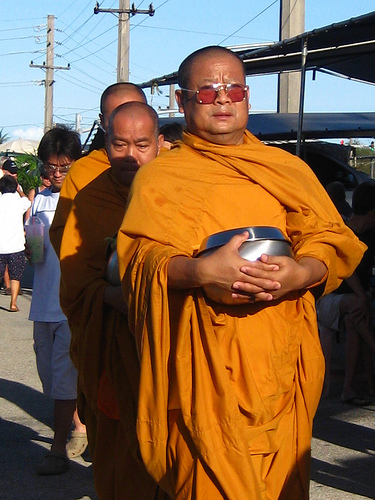

In [40]:
im = test_img[random.randint(0,1000)]
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
Image.open(im)

Normal Max search: A woman in a bathing suit is goggles into the water .
Beam Search, k=3: A young girl in a handstand into a beach .
Beam Search, k=5: A young girl in a handstand into a lake .


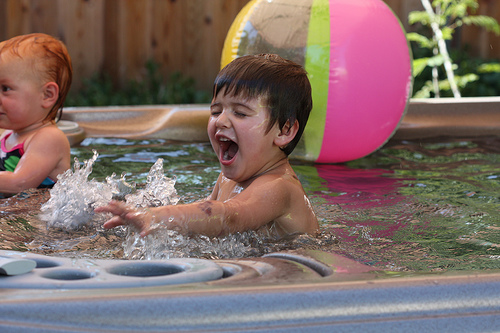

In [42]:
im = test_img[random.randint(0,1000)]
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
Image.open(im)

## Model analysis

In [0]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [0]:
def evaluate_model(descriptions, image):
    actual, predicted, predicted1, predicted2, predicted3 = list(), list(), list(), list(), list()
    i=0
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = predict_captions(image[i])
        yhat1 = beam_search_predictions(image[i], beam_index=3)
        yhat2 = beam_search_predictions(image[i], beam_index=5)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        #print(references[0:4])
        actual.append(references[0])
        predicted.append(yhat.split())
        predicted1.append(yhat1.split())
        predicted2.append(yhat2.split())
        #print(predicted)
        i+=1
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    print('---------beam search k=3-----------')
    print('BLEU-1: %f' % corpus_bleu(actual, predicted1, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted1, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted1, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted1, weights=(0.25, 0.25, 0.25, 0.25)))
    print('---------beam search k=5-----------')
    print('BLEU-1: %f' % corpus_bleu(actual, predicted2, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted2, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted2, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted2, weights=(0.25, 0.25, 0.25, 0.25)))

In [46]:
evaluate_model(test_d, test_img)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.217984
BLEU-2: 0.466887
BLEU-3: 0.633180
BLEU-4: 0.683291
---------beam search k=3-----------
BLEU-1: 0.220963
BLEU-2: 0.470067
BLEU-3: 0.635764
BLEU-4: 0.685614
---------beam search k=5-----------
BLEU-1: 0.229651
BLEU-2: 0.479219
BLEU-3: 0.643162
BLEU-4: 0.692257


##Conclussion

It seems to be a good architecture since I have trained the model very little and it performs reasonably.


Beam Search doesn`t seem to outperform default argmax output selection in this particular case. It is interesting because I expected distinguised bleu scores between different output selection models.